# Hand Gesture Data Exploration and Visualization

This notebook explores the collected hand gesture data, performs necessary preprocessing, and visualizes the results to demonstrate the separability of different gestures.

## 1. Setup and Data Loading

First, we'll import the necessary libraries and load the `landmarks_all.csv` dataset.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv('../data/landmarks_all.csv')
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
except FileNotFoundError:
    print("Error: landmarks_all.csv not found. Make sure the file is in the correct directory.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset loaded successfully.
Shape of the dataset: (1935, 64)

First 5 rows:
         x0        y0            z0        x1        y1        z1        x2  \
0  0.865438  0.868836 -2.422250e-08  0.794712  0.832070 -0.033885  0.733928   
1  0.864565  0.870643 -3.056321e-08  0.793743  0.831610 -0.035182  0.734097   
2  0.864589  0.872940 -3.081481e-08  0.794334  0.834977 -0.035766  0.734338   
3  0.864301  0.867133 -3.886262e-08  0.794079  0.831244 -0.034292  0.731370   
4  0.863715  0.870384 -3.696305e-08  0.794449  0.834556 -0.035870  0.732864   

         y2        z2        x3  ...       x18       y18       z18       x19  \
0  0.711379 -0.050399  0.727614  ...  0.893106  0.493515 -0.084399  0.882413   
1  0.709228 -0.051849  0.729188  ...  0.889509  0.496127 -0.081805  0.880499   
2  0.710406 -0.052805  0.730370  ...  0.889538  0.494773 -0.083839  0.881028   
3  0.709213 -0.050838  0.728075  ...  0.887916  0.494777 -0.083279  0.878357   
4  0.713375 -0.053820  0.728700  ...  0.887700  

## 2. Initial Data Exploration: Gesture Distribution

Let's visualize the distribution of samples across different gestures to check for class balance.

Gesture distribution plot saved to ../results/gesture_distribution.png


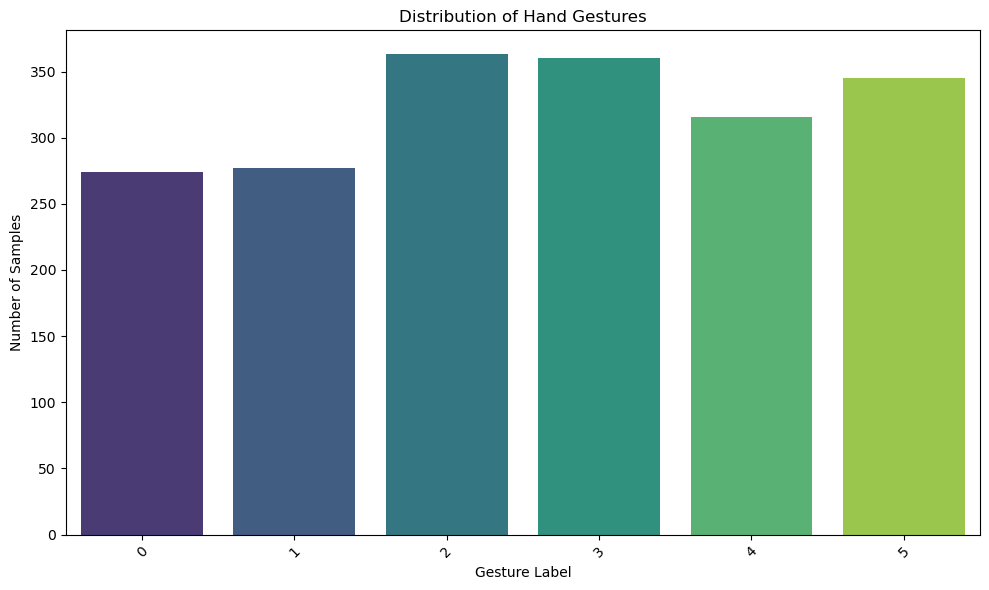

In [5]:
# Get the gesture counts
gesture_counts = df['label'].value_counts()

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=gesture_counts.index, y=gesture_counts.values, palette='viridis')
plt.title('Distribution of Hand Gestures')
plt.xlabel('Gesture Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
# Save the plot
plt.savefig('../results/gesture_distribution.png')
print("Gesture distribution plot saved to ../results/gesture_distribution.png")
plt.show()

## 3. Data Preprocessing: Feature Engineering and Normalization

We will now perform feature engineering and normalization. This involves:
1. Separating features (landmarks) from the label.
2. Normalizing the landmark coordinates to be invariant to hand size and position.
3. Potentially creating new features (e.g., distances between landmarks).

In [6]:
# Separate features (X) and labels (y)
X = df.drop('label', axis=1)
y = df['label']

# Normalize the data
# We'll use StandardScaler to normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier manipulation if needed
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Feature Engineering: Example - Calculate distances from wrist (landmark 0)
# Assuming landmarks are ordered as x0,y0,z0, x1,y1,z1, ...
# The data has 21 landmarks, each with x, y, z coordinates.
# Landmarks are in columns: x0, y0, z0, x1, y1, z1, ..., x20, y20, z20
# We need to reshape X_scaled to have shape (n_samples, n_landmarks, 3)
n_samples = X_scaled_df.shape[0]
n_landmarks = 21
n_features_per_landmark = 3

X_reshaped = X_scaled_df.values.reshape(n_samples, n_landmarks, n_features_per_landmark)

# Wrist landmark is at index 0
wrist_landmarks = X_reshaped[:, 0, :] # Shape: (n_samples, 3)

# Calculate distances from wrist for all other landmarks
distances_from_wrist = []
for i in range(1, n_landmarks):
    landmark_i = X_reshaped[:, i, :]
    # Calculate Euclidean distance: sqrt(sum((p1 - p2)^2))
    dist = np.linalg.norm(landmark_i - wrist_landmarks, axis=1)
    distances_from_wrist.append(dist)

# Concatenate new features with scaled data
distances_df = pd.DataFrame(np.array(distances_from_wrist).T, columns=[f'dist_wrist_lmk{i}' for i in range(1, n_landmarks)])

# Combine original scaled features with new distance features
X_processed = pd.concat([X_scaled_df, distances_df], axis=1)

print("Data preprocessing complete.")
print(f"Shape of processed data: {X_processed.shape}")
print("\nFirst 5 rows of processed data:")
print(X_processed.head())

Data preprocessing complete.
Shape of processed data: (1935, 83)

First 5 rows of processed data:
         x0        y0        z0        x1        y1        z1        x2  \
0  1.064332  1.620378 -0.676570  0.954602  1.922989 -0.669874  0.862050   
1  1.061655  1.632400 -0.693741  0.951282  1.919258 -0.705688  0.862712   
2  1.061728  1.647673 -0.694423  0.953306  1.946564 -0.721811  0.863657   
3  1.060845  1.609051 -0.716217  0.952432  1.916288 -0.681104  0.852038   
4  1.059051  1.630678 -0.711072  0.953700  1.943151 -0.724696  0.857885   

         y2        z2        x3  ...  dist_wrist_lmk11  dist_wrist_lmk12  \
0  1.570272 -0.735625  0.889707  ...          1.755654          1.094622   
1  1.549577 -0.764922  0.896256  ...          1.696818          1.047377   
2  1.560917 -0.784261  0.901171  ...          1.755520          1.111662   
3  1.549432 -0.744495  0.891627  ...          1.664672          1.011708   
4  1.589479 -0.804766  0.894226  ...          1.779889          1.11892

## 4. Dimensionality Reduction (PCA and t-SNE)

We will use PCA and t-SNE to reduce the dimensionality of the processed data to 2 components for visualization.

In [7]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['label'] = y.values # Add labels back for plotting

# Apply t-SNE
# t-SNE can be computationally intensive, especially for large datasets.
# We'll use a small subset if the dataset is very large, but for now, let's try with the full dataset.
# If it's too slow, consider using `n_samples = X_processed.sample(n=5000, random_state=42)`
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_processed)
tsne_df = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
tsne_df['label'] = y.values # Add labels back for plotting

print("Dimensionality reduction complete.")

Dimensionality reduction complete.


## 5. Visualization of Reduced Dimensions

Now, let's visualize the results of PCA and t-SNE, coloring points by their gesture label.

PCA visualization plot saved to ../results/pca_visualization.png


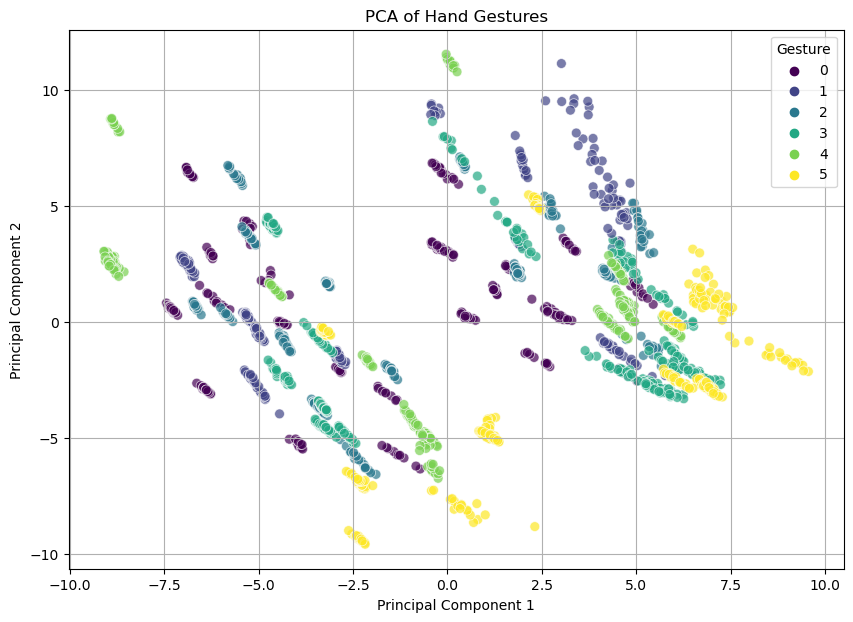

t-SNE visualization plot saved to ../results/tsne_visualization.png


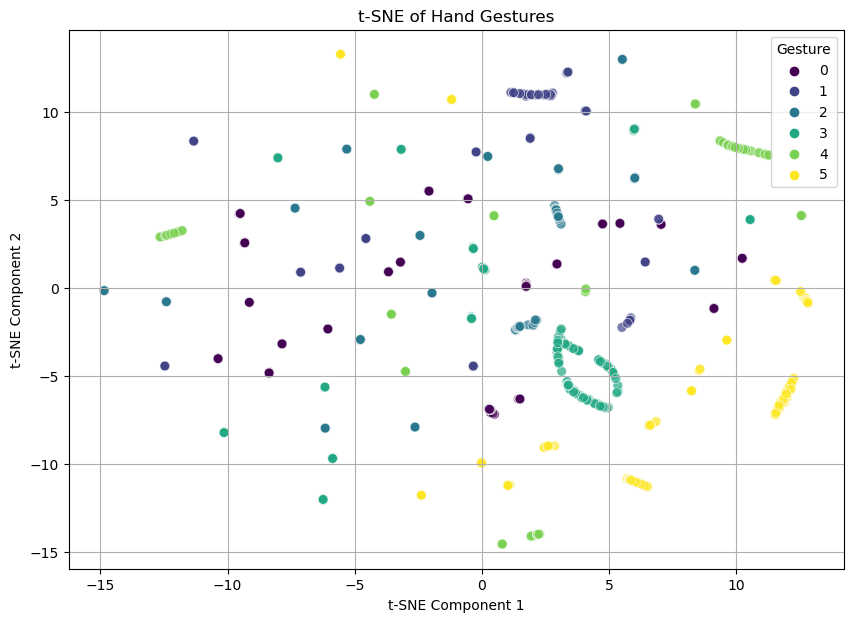

In [8]:
# Plot PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=pca_df, palette='viridis', s=50, alpha=0.7)
plt.title('PCA of Hand Gestures')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Gesture')
plt.grid(True)
# Save the plot
plt.savefig('../results/pca_visualization.png')
print("PCA visualization plot saved to ../results/pca_visualization.png")
plt.show()

# Plot t-SNE results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='label', data=tsne_df, palette='viridis', s=50, alpha=0.7)
plt.title('t-SNE of Hand Gestures')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Gesture')
plt.grid(True)
# Save the plot
plt.savefig('../results/tsne_visualization.png')
print("t-SNE visualization plot saved to ../results/tsne_visualization.png")
plt.show()

## 6. Conclusion

The visualizations show how well the different gestures are separated after preprocessing and dimensionality reduction. This forms the basis for training a gesture recognition model.